In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# UPLOAD DATASET

In [2]:
data = pd.read_csv("tyres_train.csv", sep = ",")

data.head(10)

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0
5,20.042,38,0,0.04,0.01,-0.20,2,1,160.5,0,0,0,5.96,NaN,1,0
6,21.172,33,1,0.39,0.01,-2.28,0,0,470.0,3,0,0,6.47,NaN,1,0
7,16.706,32,0,0.62,0.05,-3.96,3,1,148.5,7,2,0,5.39,NaN,1,0
8,17.616,25,1,0.16,0.01,-6.88,0,1,103.5,8,0,1,5.32,63.6,1,0
9,17.370,34,0,0.27,0.01,-1.28,2,0,345.5,5,2,0,6.31,NaN,0,0


# DATA OBSERVATION AND PREPARATION

In [3]:
data.dtypes

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object

Categorical variables are no "object" type, but need to be transformed anyway in Dummies 

In [4]:
data.isnull().sum()

vulc                  0
perc_nat_rubber       0
wiring_strength       0
weather               0
perc_imp              0
temperature           0
tread_type            0
tyre_season           0
elevation             0
month                 0
tread_depth           0
tyre_quality          0
perc_exp_comp         0
diameter           2110
add_layers            0
failure               0
dtype: int64

The variable "diameter" contains in majority NaN values, so it is impossible to proceed with the method of substitution.

It is better to drop the entire column.

In [5]:
#dropping all column "diameter"
d="diameter"
data_dropped = data.drop(columns=d)

data_dropped.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,1,0


In [6]:
data_dropped.isnull().sum()
# no more NaN observations

vulc               0
perc_nat_rubber    0
wiring_strength    0
weather            0
perc_imp           0
temperature        0
tread_type         0
tyre_season        0
elevation          0
month              0
tread_depth        0
tyre_quality       0
perc_exp_comp      0
add_layers         0
failure            0
dtype: int64

The dataset now doesn't contain any NaN values, so we can start to visualize the data and apply the required transformation.

failure
0    1992
1    1008
dtype: int64


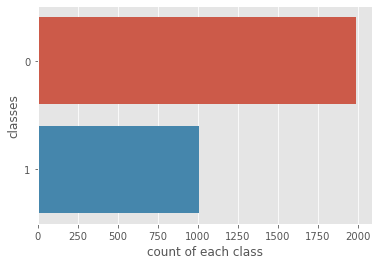

In [7]:
print(data_dropped.groupby('failure').size())

%matplotlib inline
plt.style.use('ggplot')

#Visualize Class Counts
sns.countplot(y=data_dropped.failure ,data=data_dropped)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

The dataset is unbalanced, so we will try to perform oversampling on the training set in the next phase of identification of the best model.

## Categorical variables

We select the categorical variables based on the Dataset description.

In [8]:
selection_categorical=['tread_type', 'tyre_season','month', 'tread_depth', 'wiring_strength', 'tyre_quality',
       'add_layers']
data_categorical=data_dropped[selection_categorical]
data_categorical.head()

,tread_type,tyre_season,month,tread_depth,wiring_strength,tyre_quality,add_layers
0,0,1,8,0,1,1,1
1,2,0,11,1,1,0,1
2,0,0,0,1,1,0,1
3,1,0,7,3,1,1,1
4,0,1,2,2,2,0,1


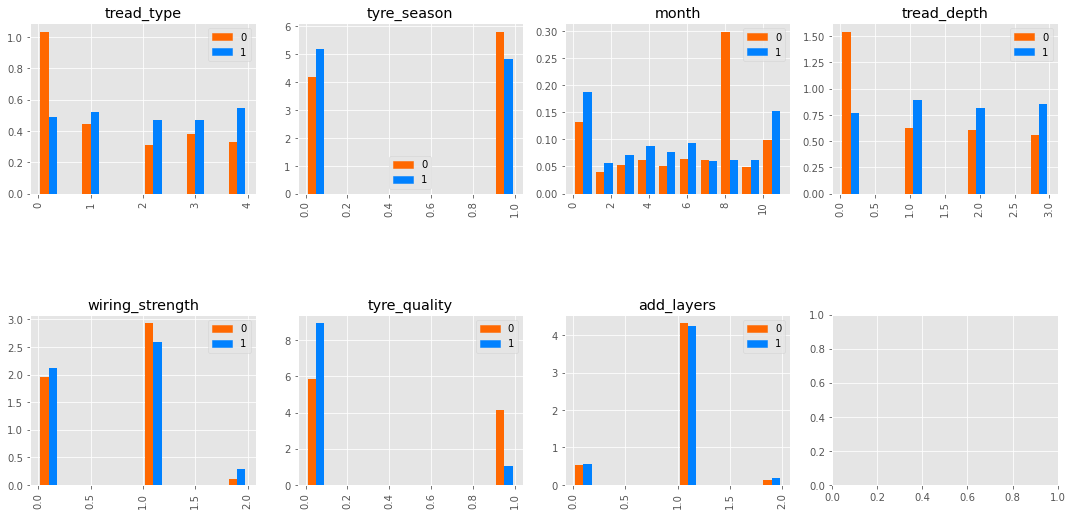

In [9]:
# Visualize categorical variables
data_0=data_categorical[data_dropped['failure']==0] # records wih target==0
data_1=data_categorical[data_dropped['failure']==1] # records wih target==1

cmap = plt.get_cmap('jet')
col=[cmap(0.8),cmap(0.25)]
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in data_categorical.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([data_0[x],data_1[x]],density=True,color=col)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    handles = [Rectangle((0,0),1,1,color=c)for c in col]
    labels= ["0","1"]
    plt.legend(handles, labels)
    i+=1
plt.show()

The variable "add_layers" has the same distibution on the observation with target 0 and 1, so we eliminate it because it is not influent in the the analysis of the classification task.

In [10]:
ad="add_layers"
data_categorical = data_categorical.drop(columns=ad)
selection_categorical = ['tread_type', 'tyre_season', 'tread_depth','month', 'wiring_strength', 'tyre_quality']

### Create dummies with the OneHotEncoder method

Now that we have selected the categorical variables in our Dataset, we can transorm them in dummies, trough the OneHotEncoder method; we decided to use this mehod to increase the robustness int he analysis, in case the new dataset contains new values of in the variables.

In [11]:
from sklearn.preprocessing import OneHotEncoder
encod = OneHotEncoder(handle_unknown='ignore')

data_dummies=pd.DataFrame()
for i in range(len(selection_categorical)):
    encod.fit(data_dropped[[selection_categorical[i]]].astype(str))
    dummies = encod.transform(data_dropped[[selection_categorical[i]]].astype(str)).toarray()
    for k in range(len(encod.categories_[0])):
        encod.categories_[0][k]=selection_categorical[i]+"_"+str(encod.categories_[0][k])
    data_dummies=pd.concat([data_dummies,pd.DataFrame(dummies,columns=encod.categories_[0])],axis=1)
    
data_dummies.head()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,month_5,month_6,month_7,month_8,month_9,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Numerical Variables

We select the numerical variables based on the Dataset description, without the variable "diameter" that has been eliminated previously.

In [12]:
selection_numerical=['vulc', 'perc_nat_rubber', 'weather', 'perc_imp', 'temperature', 'elevation',
       'perc_exp_comp','failure']
data_numerical=data_dropped[selection_numerical]
data_numerical.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,failure
0,17.990,26,0.16,0.01,-8.12,332.5,5.13,0
1,20.704,36,0.30,0.01,-4.52,328.0,6.15,0
2,19.156,34,0.30,0.01,-1.08,247.0,6.36,0
3,16.802,35,0.19,0.02,7.44,408.0,6.62,0
4,17.140,23,0.39,0.01,30.52,308.0,6.15,0


(1992, 8)
(1008, 8)


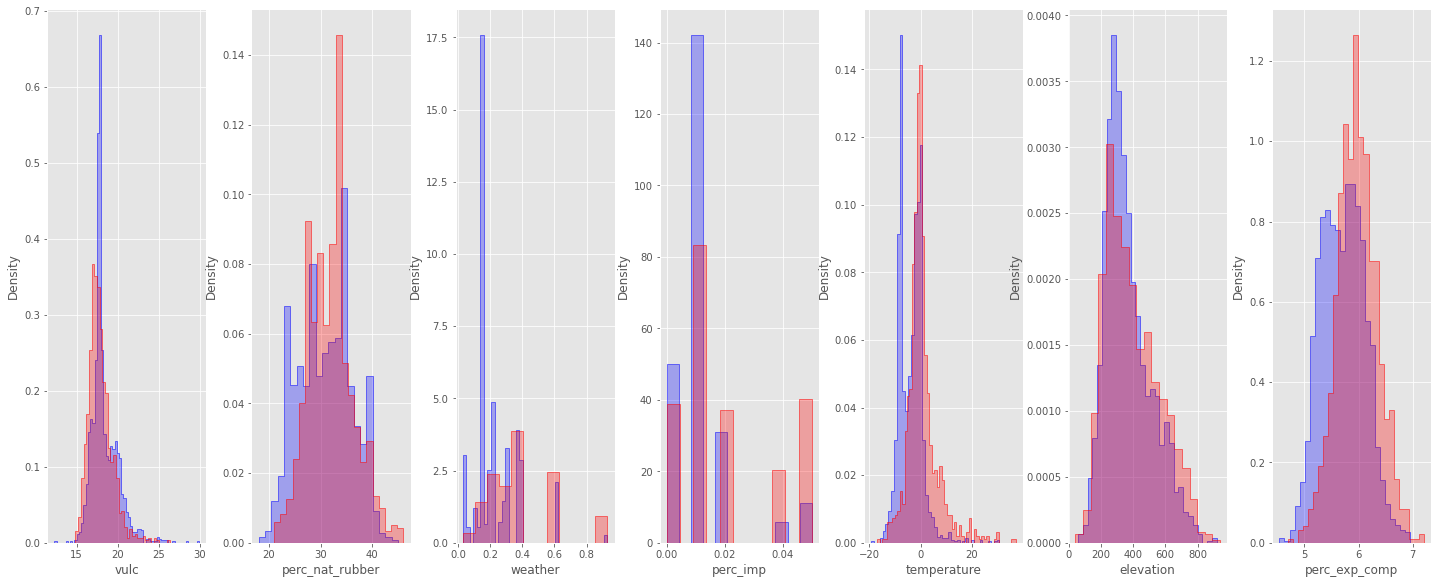

In [13]:
# Visualize numerical variables
X0 = data_numerical[data_numerical['failure']==0]
X1 = data_numerical[data_numerical['failure']==1]
print(X0.shape)
print(X1.shape)
fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(20,8))
fig.tight_layout()

data_num = data_numerical.iloc[:,0:-1]

for i, ax in zip(range(data_num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()


The variable "elevation" has the same distibution on the observations with target 0 and 1, so we eliminate it because it is not influent in the the analysis of the classification task.

In [ ]:
# elevation has the same distibution on target 0 and 1 --> we eliminate it because not important for the analysis
#e="elevation"
#data_numerical = data_numerical.drop(columns=e)

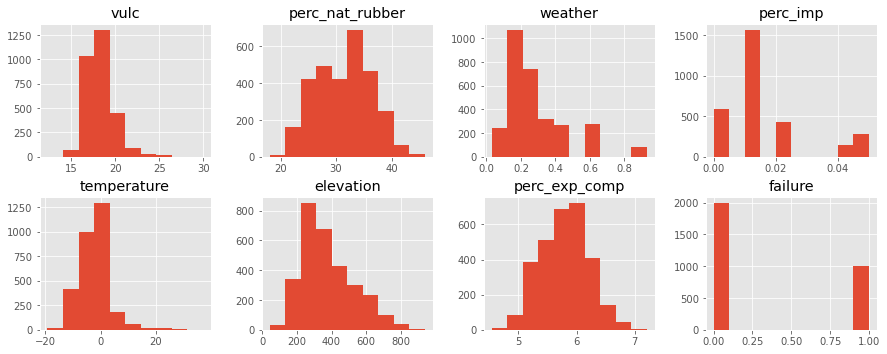

In [14]:
data_hist=data_numerical.hist(layout=(4,4), figsize=(15,12))

The variables present a quite symmetric distribution; some of them is slighy right skewed but does not present an exponential decrease, so we try take the original distribution without applying any logaritmic distribution.

<AxesSubplot:>

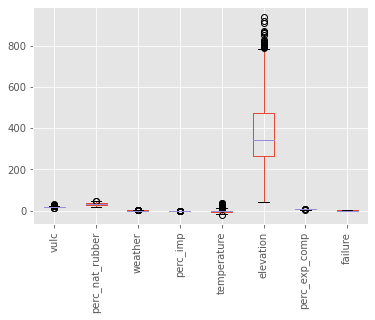

In [15]:
data_numerical.boxplot(rot=90)

The scale of numerical variables is too different, so we will scale the train set in a next step and apply the same scaler on the test set.

Now that all the transormation on the original Dataset are concluded, we can create the final Dataset with all the modifications and target variable included

In [16]:
df=pd.concat([data_dummies,data_numerical],axis=1)
df['failure']=data_dropped['failure']

df.tail()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,failure
2995,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,17.818,29,0.39,0.01,7.28,287.5,5.68,1
2996,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,17.076,30,0.22,0.00,-1.44,152.5,5.81,1
2997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,16.170,33,0.39,0.01,-3.44,235.0,5.57,0
2998,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,18.872,37,0.03,0.00,-0.76,290.0,5.89,0
2999,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,20.272,33,0.06,0.00,2.80,405.0,6.00,0


# Creation of Train and Test Sets

In [17]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1] #[-1]]

In [18]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    test_size =0.20, 
                                                    #shuffle is set True by default,
                                                    stratify=y, #preserve target proportions 
                                                    random_state= 42) 

print(X_train1.shape, X_test1.shape)

(2400, 35) (600, 35)


Now that the train set and the test set are separated we can scale tha numerical data on the train set and then apply the same scaler to the test set.

Once we have the new data scaled, we drop the previous numerical data and substitute them with the new once.

In [19]:
# we have to scale the numerical variables of the train set --> then we apply the same scaler to the numerical variables of the test set
numerical=['vulc','perc_nat_rubber', 'weather', 'perc_imp', 'elevation','temperature', 'perc_exp_comp']


independent_variablesA=X_train1[numerical] #no target
independent_variablesB=X_test1[numerical] #no target

scaler_train = StandardScaler().fit(independent_variablesA) 
scaled_train = pd.DataFrame(scaler_train.transform(independent_variablesA))
scaled_train.columns = independent_variablesA.columns

scaled_test = pd.DataFrame(scaler_train.transform(independent_variablesB))
scaled_test.columns = independent_variablesB.columns
print(scaled_test.shape, scaled_train.shape)
scaled_test.head(10)

(600, 7) (2400, 7)


,vulc,perc_nat_rubber,weather,perc_imp,elevation,temperature,perc_exp_comp
0,-0.299530,-1.644094,-0.656931,-0.316066,-0.627192,-0.877116,-1.436695
1,-0.266915,-1.241992,1.828084,2.514375,1.044878,1.782521,1.039006
2,-0.312074,-1.241992,-0.656931,-0.316066,0.239807,-0.945488,-1.703683
3,-0.818857,0.969568,0.585577,-0.316066,0.044244,0.339890,1.184635
4,-0.461349,-1.040941,0.585577,-0.316066,-0.529410,0.025383,-0.708548
5,-0.217993,-1.241992,-0.656931,-0.316066,-0.659786,-1.034370,-0.902721
6,-1.521328,1.773772,3.502768,1.806765,-0.620673,1.078299,2.252585
7,-0.151509,-1.443043,-0.656931,-0.316066,-0.236064,-1.061719,-1.752226
8,0.714036,0.969568,-1.305195,-0.316066,1.729350,0.189474,0.820561
9,-0.663310,-0.638839,0.477532,0.391544,0.565747,2.103866,2.592387


<AxesSubplot:>

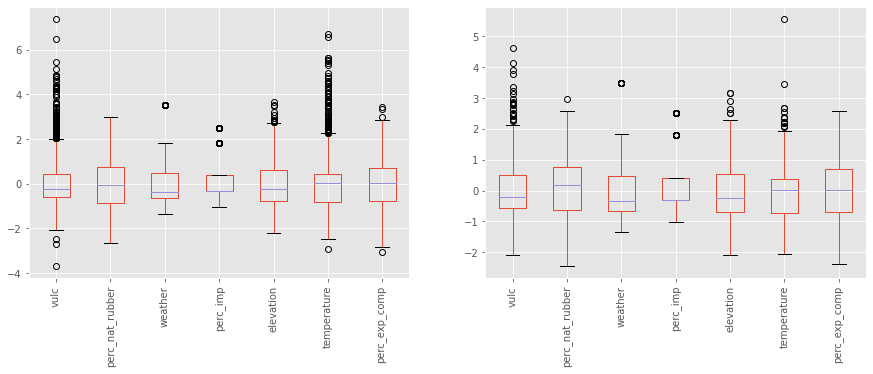

In [20]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

scaled_train.boxplot(rot=90,ax=axes[0])
scaled_test.boxplot(rot=90,ax=axes[1])

The two sets have been scaled correctly, so we can merge them with the categorical variables.

In [21]:
# subsitute original numerical variables with scaled numerical variables
scaled_train.index= independent_variablesA.index
scaled_test.index= independent_variablesB.index

train_dropped = X_train1.drop(columns=numerical)
test_dropped = X_test1.drop(columns=numerical)
print(test_dropped.shape, train_dropped.shape)

Xtrain2=pd.concat([train_dropped,scaled_train],axis=1)
Xtest2=pd.concat([test_dropped,scaled_test],axis=1)


(600, 28) (2400, 28)


In [22]:
# check correct substitution
print(Xtest2.isnull().sum(), Xtrain2.isnull().sum())

tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        0
tread_depth_1        0
tread_depth_2        0
tread_depth_3        0
month_0              0
month_1              0
month_10             0
month_11             0
month_2              0
month_3              0
month_4              0
month_5              0
month_6              0
month_7              0
month_8              0
month_9              0
wiring_strength_0    0
wiring_strength_1    0
wiring_strength_2    0
tyre_quality_0       0
tyre_quality_1       0
vulc                 0
perc_nat_rubber      0
weather              0
perc_imp             0
elevation            0
temperature          0
perc_exp_comp        0
dtype: int64 tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        

The substitution has been executed correctly so we can create the new scaled train and test sets.

In [23]:
# create new scaled datasets
df_train=pd.concat([Xtrain2,y_train1],axis=1)
df_test=pd.concat([Xtest2,y_test1], axis=1)

df_test.head(10)

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,elevation,temperature,perc_exp_comp,failure
2448,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,-0.299530,-1.644094,-0.656931,-0.316066,-0.627192,-0.877116,-1.436695,0
982,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,-0.266915,-1.241992,1.828084,2.514375,1.044878,1.782521,1.039006,1
773,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,-0.312074,-1.241992,-0.656931,-0.316066,0.239807,-0.945488,-1.703683,0
901,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.818857,0.969568,0.585577,-0.316066,0.044244,0.339890,1.184635,1
399,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,-0.461349,-1.040941,0.585577,-0.316066,-0.529410,0.025383,-0.708548,1
2297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,-0.217993,-1.241992,-0.656931,-0.316066,-0.659786,-1.034370,-0.902721,0
1615,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-1.521328,1.773772,3.502768,1.806765,-0.620673,1.078299,2.252585,1
2109,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,-0.151509,-1.443043,-0.656931,-0.316066,-0.236064,-1.061719,-1.752226,0
1042,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.714036,0.969568,-1.305195,-0.316066,1.729350,0.189474,0.820561,0
17,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.663310,-0.638839,0.477532,0.391544,0.565747,2.103866,2.592387,1


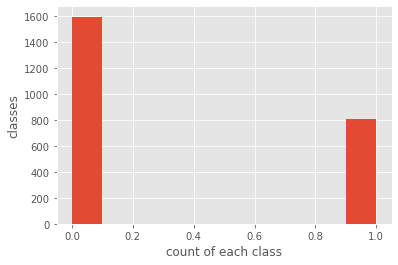

0    1594
1     806
Name: failure, dtype: int64

In [24]:
plt.hist(y_train1)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
df_train.failure.value_counts()

The original Dataset was unbalanced and the train set (randomly generated from the original one) remains unbalanced, so we can try to perform oversampling on target 1 to see if the F1 score gets better during identificaiton of the best model.

In [25]:
#resample train set
df_majority = df_train[df_train.failure==0]
df_minority = df_train[df_train.failure==1] 
print(df_majority.shape[0],df_minority.shape[0])

df_minority_overs = resample(df_minority, 
                                replace=True,
                                n_samples=1300, # not complete oversampling
                                random_state=42)  

df_overs_train = pd.concat([df_minority_overs, df_majority])

df_overs_train.failure.value_counts()


1594 806


0    1594
1    1300
Name: failure, dtype: int64

In [26]:
from sklearn.utils import shuffle
df_oversampled_train = shuffle(df_overs_train)

We will try to perform the identification of the best model of the oversampled data and the non-oversampled data, to compare the 2 F1 score; so we idenfify 2 different DataFrames to be used as train and 1 single DataFrame to be used as Test set. 

In [27]:
#Separate X and y on the new DataFrames
# Dataframes with oversample
X2_train=df_overs_train.iloc[:,0:-1]
y2_train=df_overs_train.iloc[:,-1]

#DataFrames without oversample
X_train=df_train.iloc[:,0:-1]
y_train=df_train.iloc[:,-1]

X_test = df_test.iloc[:,0:-1]
y_test = df_test.iloc[:,-1]

print(X2_train.shape,X_train.shape,X_test.shape)

(2894, 35) (2400, 35) (600, 35)


# Models 

## Needed functions 

Here we define some functions that will be used in the following analysis to perform the search of the best parameters and the visualization of the ROC curve

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [52]:
def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)))
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred)))
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
 

In [53]:
def hyperp_search_over(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X2_train, y2_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X2_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y2_train, y_pred_train), f1_score(y_test, y_pred)))
    print("precision  train %.3f   test %.3f" % (precision_score(y2_train, y_pred_train), precision_score(y_test, y_pred)))
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
 

In [37]:
def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

## Research of the best model

For every model family of model, we search for the best model using the non-oversampled train set and the oversampled train set, then compare the F1 score with the same test set.

If the values of F1 score obtained with the oversampled train will result better, we will try to fit the best model found with the non-oversampled data.

### TREE

In [38]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['gini','entropy'], 
              'max_depth': [2,3,4],
              'min_samples_split': [2,4,6,8,12,16,18,20],
              'min_samples_leaf': [4,6,8,12,16,18,20]}

In [54]:
hyperp_search(classifier,parameters)

f1_train: 0.523424 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
f1         train 0.635   test 0.592
precision  train 0.675   test 0.611

[[324  74]
 [ 86 116]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       398
           1       0.61      0.57      0.59       202

    accuracy                           0.73       600
   macro avg       0.70      0.69      0.70       600
weighted avg       0.73      0.73      0.73       600



In [55]:
hyperp_search_over(classifier,parameters)

f1_train: 0.711945 using {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
f1         train 0.723   test 0.617
precision  train 0.643   test 0.497

[[232 166]
 [ 38 164]]
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       398
           1       0.50      0.81      0.62       202

    accuracy                           0.66       600
   macro avg       0.68      0.70      0.66       600
weighted avg       0.74      0.66      0.67       600



In [71]:
model_Tree= DecisionTreeClassifier(criterion= 'entropy', max_depth= 3, min_samples_leaf= 4, min_samples_split= 2)

In [72]:
model_Tree.fit(X_train, y_train)
y_pred_train=model_Tree.predict(X_train)
y_pred=model_Tree.predict(X_test)

print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))

f1_train:  0.4161434977578475
f1_test:  0.40433212996389895


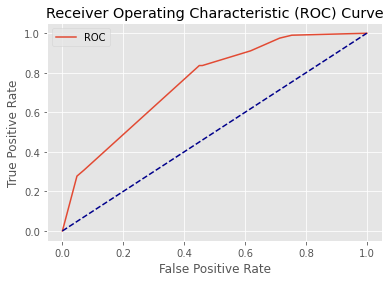

AUC: 0.75


In [83]:
#curva ROC
fpr1,tpr1=roc(model_Tree,X_train,y_train,X_test,y_test)

#### Plotting tree

In [ ]:
from sklearn import tree
r = tree.export_text(model_Tree,feature_names=X_test.columns.tolist(),max_depth = 6 )
print(r)

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_Tree, 
                   feature_names=X_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)

### KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(50,120,2)}


In [58]:
hyperp_search(classifier,parameters)

f1_train: 0.527614 using {'n_neighbors': 52}
f1         train 0.557   test 0.537
precision  train 0.705   test 0.677

[[355  43]
 [112  90]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       398
           1       0.68      0.45      0.54       202

    accuracy                           0.74       600
   macro avg       0.72      0.67      0.68       600
weighted avg       0.73      0.74      0.73       600



In [59]:
hyperp_search_over(classifier,parameters)

f1_train: 0.689664 using {'n_neighbors': 92}
f1         train 0.699   test 0.591
precision  train 0.721   test 0.578

[[309  89]
 [ 80 122]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       398
           1       0.58      0.60      0.59       202

    accuracy                           0.72       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.72      0.72      0.72       600



In [73]:
model_knn = KNeighborsClassifier(n_neighbors=92)

In [74]:
model_knn.fit(X_train, y_train)
y_pred_train=model_knn.predict(X_train)
y_pred=model_knn.predict(X_test)

print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))

f1_train:  0.5241809672386896
f1_test:  0.5125000000000001


In [ ]:
#curva ROC
fpr2,tpr2=roc(model_knn,X_train,y_train,X_test,y_test)

### NAYVE BAYES

In [60]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred_train=model.predict(X_train)

y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_train: ", f1_score(y_train, y_pred_train))


print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_train:  0.5921625544267054
f1_test:  0.6073500967117988
[[240 158]
 [ 45 157]]
              precision    recall  f1-score   support

           0       0.84      0.60      0.70       398
           1       0.50      0.78      0.61       202

    accuracy                           0.66       600
   macro avg       0.67      0.69      0.66       600
weighted avg       0.73      0.66      0.67       600



In [76]:
model.fit(X2_train, y2_train)
y_pred_train=model.predict(X2_train)

y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_train: ", f1_score(y2_train, y_pred_train))


print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_train:  0.673421141506248
f1_test:  0.6142034548944337
[[239 159]
 [ 42 160]]
              precision    recall  f1-score   support

           0       0.85      0.60      0.70       398
           1       0.50      0.79      0.61       202

    accuracy                           0.67       600
   macro avg       0.68      0.70      0.66       600
weighted avg       0.73      0.67      0.67       600



In [ ]:
#curva ROC
fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)

### LOGISTIC REGRESSION

In [61]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "penalty":['l2'], "max_iter":[500,1000,10000] }

In [62]:
hyperp_search(classifier,parameters)

f1_train: 0.562911 using {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}
f1         train 0.586   test 0.581
precision  train 0.688   test 0.712

[[358  40]
 [103  99]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       398
           1       0.71      0.49      0.58       202

    accuracy                           0.76       600
   macro avg       0.74      0.69      0.71       600
weighted avg       0.75      0.76      0.75       600



In [63]:
hyperp_search_over(classifier,parameters)

f1_train: 0.681710 using {'C': 10, 'max_iter': 500, 'penalty': 'l2'}
f1         train 0.690   test 0.667
precision  train 0.706   test 0.619

[[308  90]
 [ 56 146]]
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       398
           1       0.62      0.72      0.67       202

    accuracy                           0.76       600
   macro avg       0.73      0.75      0.74       600
weighted avg       0.77      0.76      0.76       600



In [64]:
model_Log = LogisticRegression(C=10, max_iter=500,penalty='l2')

In [65]:
model_Log.fit(X_train, y_train)
y_pred_train=model_Log.predict(X_train)
y_pred=model_Log.predict(X_test)

print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))



f1_train:  0.5890603085553997
f1_test:  0.5919540229885059


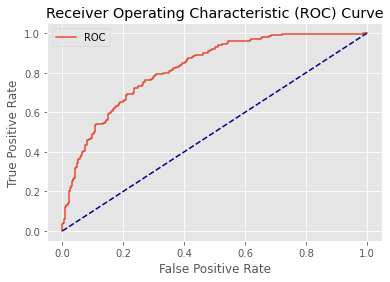

AUC: 0.82


In [84]:
#curva ROC
fpr4,tpr4=roc(model_Log,X_train,y_train,X_test,y_test)

### SVM

In [66]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','rbf','poly','sigmoid'], "C":[0.001,0.005,0.009],"gamma":[0.01,0.1,1], "degree":[2,3]}


In [67]:
hyperp_search(classifier,parameters)

f1_train: 0.550773 using {'C': 0.009, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
f1         train 0.612   test 0.511
precision  train 0.768   test 0.649

[[352  46]
 [117  85]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       398
           1       0.65      0.42      0.51       202

    accuracy                           0.73       600
   macro avg       0.70      0.65      0.66       600
weighted avg       0.72      0.73      0.71       600



In [68]:
hyperp_search_over(classifier,parameters)

f1_train: 0.804750 using {'C': 0.009, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
f1         train 0.978   test 0.480
precision  train 0.973   test 0.520

[[315  83]
 [112  90]]
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       398
           1       0.52      0.45      0.48       202

    accuracy                           0.68       600
   macro avg       0.63      0.62      0.62       600
weighted avg       0.66      0.68      0.67       600



In [ ]:
model = SVC(C=0.009, kernel='poly',degree=2,gamma=1,probability=True)

In [ ]:
fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)

### NEURAL NETWORK

In [80]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(7,5,3,2),(7,5,3),(10, 5),(10, 5,2)],  "max_iter": [1000,5000,10000], "alpha": [0.001,0.009,0.1,0.9,1]}


In [81]:
hyperp_search(classifier,parameters)

f1_train: 0.594354 using {'alpha': 0.001, 'hidden_layer_sizes': (7, 5, 3, 2), 'max_iter': 5000}
f1         train 0.710   test 0.589
precision  train 0.732   test 0.566

[[303  95]
 [ 78 124]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       398
           1       0.57      0.61      0.59       202

    accuracy                           0.71       600
   macro avg       0.68      0.69      0.68       600
weighted avg       0.72      0.71      0.71       600



In [82]:
hyperp_search_over(classifier,parameters)

f1_train: 0.765088 using {'alpha': 0.009, 'hidden_layer_sizes': (7, 5, 3, 2), 'max_iter': 5000}
f1         train 0.798   test 0.603
precision  train 0.668   test 0.480

[[220 178]
 [ 38 164]]
              precision    recall  f1-score   support

           0       0.85      0.55      0.67       398
           1       0.48      0.81      0.60       202

    accuracy                           0.64       600
   macro avg       0.67      0.68      0.64       600
weighted avg       0.73      0.64      0.65       600



In [ ]:
model_MLP=MLPClassifier(hidden_layer_sizes=(10,5,2), alpha=0.09, max_iter=5000)


In [ ]:
#curva ROC
fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)

### RANDOM FOREST

In [77]:
from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     np.arange(2,8,1),
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(2,5,1), 
              'min_samples_split': np.arange(4,18,1),
              'min_samples_leaf' : np.arange(4,18,1),
              'class_weight' : ["balanced"]
             };



In [78]:
hyperp_search(classifier,parameters)

f1_train: 0.643343 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 6}
f1         train 0.652   test 0.618
precision  train 0.525   test 0.497

[[231 167]
 [ 37 165]]
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       398
           1       0.50      0.82      0.62       202

    accuracy                           0.66       600
   macro avg       0.68      0.70      0.66       600
weighted avg       0.74      0.66      0.67       600



In [79]:
hyperp_search_over(classifier,parameters)

f1_train: 0.736852 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 17, 'n_estimators': 7}
f1         train 0.743   test 0.579
precision  train 0.634   test 0.456

[[207 191]
 [ 42 160]]
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       398
           1       0.46      0.79      0.58       202

    accuracy                           0.61       600
   macro avg       0.64      0.66      0.61       600
weighted avg       0.70      0.61      0.62       600



In [ ]:
model_RandomForest=RandomForestClassifier(class_weight= 'balanced', criterion='entropy', max_depth=4,min_samples_leaf = 12, min_samples_split= 4, n_estimators= 7)


In [ ]:
#curva ROC
fpr7,tpr7=roc(model_RandomForest,X_train,y_train,X_test,y_test)

# CHOICE OF THE MODEL